In [1]:
import numpy as np
import os
import pysynphot as s
import pandas as pd
import matplotlib.pyplot as plt

/home/mldantas/miniconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [11]:
# Paths ------------------------------------------------------------------------------------------------------------
filters_path         = '/home/mldantas/Dropbox/DoutoradoIAG/Challenge/Filters' # where are your filters
jpas_filters_folder  = 'JPAS_filters'                                          # folder where the filters are
jplus_filters_folder = 'JPLUS_SDSS_filters'                                    # folder where the filters are
jpas_filters_list    = 'jpas_filters_list.txt'                                 # file w/ a list of filters' files
jplus_filters_list   = 'jplus_filters_list.txt'                                # file w/ a list of filters' files
test_specs           = '/home/mldantas/Dropbox/DoutoradoIAG/Challenge/Sanity_Check/Specs'   # where your spectra are
results_path         = '/home/mldantas/Dropbox/DoutoradoIAG/Challenge/Sanity_Check/Results' # where do you wish to
                                                                                            # save your results
specs_list_path      = '/home/mldantas/Dropbox/DoutoradoIAG/Challenge/Sanity_Check' # folder w/ a list of spec files
specs_list_file      = 'specslist2.txt'                                             # file w/ a list of spec files 

In [12]:
# Reading your files -----------------------------------------------------------------------------------------------
jpas_filters_list  = np.loadtxt(os.path.join(filters_path, jpas_filters_list), dtype=str)
jplus_filters_list = np.loadtxt(os.path.join(filters_path, jplus_filters_list), dtype=str)
specs_list         = np.loadtxt(os.path.join(specs_list_path, specs_list_file), dtype=str)

In [13]:
# Setting the T80 M1 effective area in cm^2 ------------------------------------------------------------------------
s.setref(area=4400)

0443.51873.152.txt


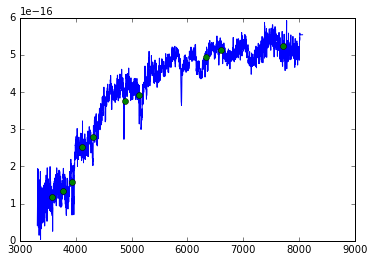

1019.52707.261.txt


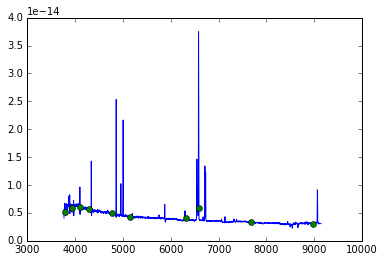

1180.52995.637.txt
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.


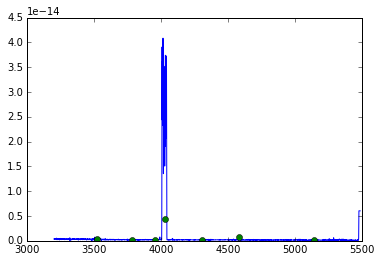

1665.52976.514.txt


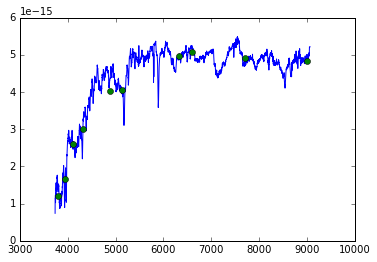

2231.53816.545.txt


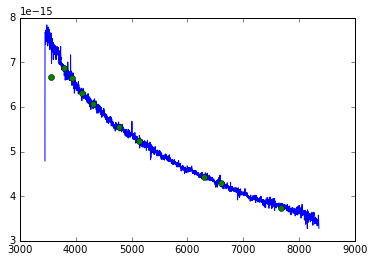

In [25]:
# Simulating photometry for your spectra using the selected survey filters -----------------------------------------
all_jplus = []
for each_spectrum in specs_list:
    print each_spectrum
    filter_name     = []
    photometry      = []
    photometry_temp = []
    photometry_flam = []
    lambda_eff      = []
    for jplus_filters in jplus_filters_list:
        # saving an array with the filters names -------------------------------------------------------------------
        filter_name_i          = jplus_filters.split('.')[0]
        filter_name.append(filter_name_i)
        
        # convolution ----------------------------------------------------------------------------------------------
        jplus_filter_bandpass = s.FileBandpass(os.path.join(jplus_filters_path, jplus_filters))
        sdss_spectrum         = s.FileSpectrum(os.path.join(test_specs, each_spectrum))        # the entire spectrum
        index                 = np.where(sdss_spectrum.flux > 0)  # selecting only the positive part of the spectrum
        sdss_spectrum2        = s.ArraySpectrum(wave=sdss_spectrum.wave[index], flux=sdss_spectrum.flux[index], 
                                                fluxunits=sdss_spectrum.fluxunits, 
                                                waveunits=sdss_spectrum.waveunits)
        binset = jplus_filter_bandpass.wave  # this is very very important! 
                                             # don't change this unless 
                                             # you are absolutely sure of what you are doing!
        ## convolved photometry ------------------------------------------------------------------------------------
        photometry_i = s.Observation(sdss_spectrum2, jplus_filter_bandpass, binset=binset, force='extrap')
        
        ## effective wavelength ------------------------------------------------------------------------------------
        lambda_eff_i = photometry_i.efflam()
        lambda_eff.append(lambda_eff_i)
        
        ## checking if the simulated photometry is "virtual" and letting those away --------------------------------
        if lambda_eff_i >= sdss_spectrum2.wave.max():
            new_photometry_i = -999
            photometry.append(new_photometry_i)
            photometry_flam.append(new_photometry_i)
            
        elif lambda_eff_i <= sdss_spectrum2.wave.min():
            new_photometry_i = -999
            photometry.append(new_photometry_i)
            photometry_flam.append(new_photometry_i)
            
        else:
            photometry.append(photometry_i.effstim('abmag'))
            photometry_flam_i = photometry_i.effstim('flam')
            photometry_flam.append(photometry_flam_i)
        

    # putting the iterated items into arrays -----------------------------------------------------------------------    
    filter_name       = np.array(filter_name)            # name of each filter
    photometry        = np.array(photometry)             # in magnitudes
    lambda_eff        = np.array(lambda_eff)             # effective wavelengths of the filters
    photometry_flam   = np.array(photometry_flam)        # in flux of lambda
    photometry_fnu    = 10**(-0.4*(photometry + 48.60))  # in flux of nu
    
    # plots --------------------------------------------------------------------------------------------------------
    plot01 = plt.plot(sdss_spectrum2.wave, sdss_spectrum2.flux, '-')
    plot02 = plt.plot(lambda_eff[[photometry_flam!=-999]], photometry_flam[[photometry_flam!=-999]], 'o')
    plt.savefig(os.path.join(results_path, os.path.split(each_spectrum)[-1][0:14]+'_JPLUS.png'), dpi = 100)
    plt.show()
    
    # saving the newley calculated photometry ----------------------------------------------------------------------
    galaxy_simulation_abmag = np.vstack((filter_name, photometry))
    galaxy_simulation_abmag = pd.DataFrame(galaxy_simulation_abmag)
    galaxy_simulation_abmag.to_csv(os.path.join(results_path, os.path.split(each_spectrum)[-1][0:14]
                                                +'_JPLUS_abmag.csv'), sep=',', header=None, index=False)
    galaxy_simulation_fnu = np.vstack((filter_name, photometry_fnu))
    galaxy_simulation_fnu = pd.DataFrame(galaxy_simulation_fnu)
    galaxy_simulation_fnu.to_csv(os.path.join(results_path, os.path.split(each_spectrum)[-1][0:14]
                                              +'_JPLUS_fnu.csv'), sep=',', header=None, index=False)
    

0443.51873.152.txt


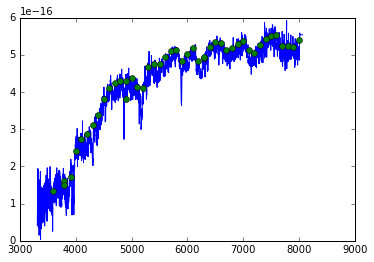

1019.52707.261.txt


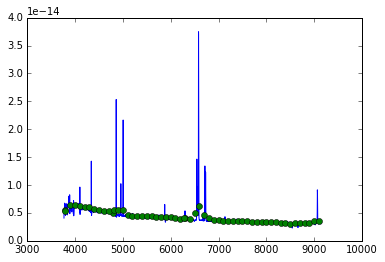

1180.52995.637.txt
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained

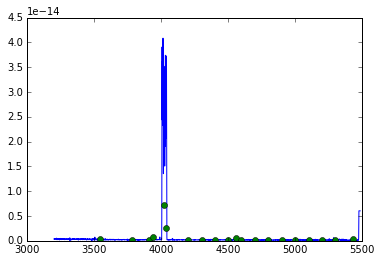

1665.52976.514.txt


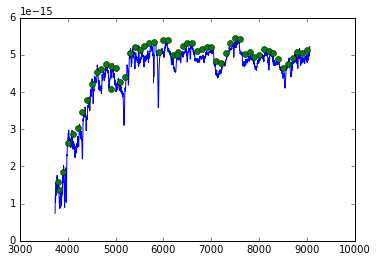

2231.53816.545.txt


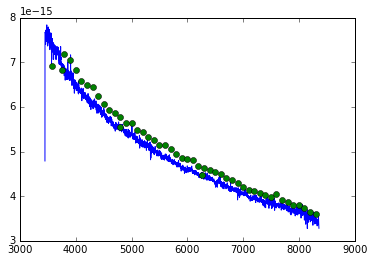

In [26]:
# Simulating photometry for your spectra using the selected survey filters -----------------------------------------
all_jpas = []
for each_spectrum in specs_list:
    print each_spectrum
    filter_name     = []
    photometry      = []
    photometry_temp = []
    photometry_flam = []
    lambda_eff      = []
    for jpas_filters in jpas_filters_list:
        # saving an array with the filters names -------------------------------------------------------------------
        filter_name_i          = jpas_filters.split('.')[0]
        filter_name.append(filter_name_i)
        
        # convolution ----------------------------------------------------------------------------------------------
        jpas_filter_bandpass = s.FileBandpass(os.path.join(jpas_filters_path, jpas_filters))
        sdss_spectrum         = s.FileSpectrum(os.path.join(test_specs, each_spectrum))        # the entire spectrum
        index                 = np.where(sdss_spectrum.flux > 0)  # selecting only the positive part of the spectrum
        sdss_spectrum2        = s.ArraySpectrum(wave=sdss_spectrum.wave[index], flux=sdss_spectrum.flux[index], 
                                                fluxunits=sdss_spectrum.fluxunits, 
                                                waveunits=sdss_spectrum.waveunits)
        binset = jpas_filter_bandpass.wave  # this is very very important! 
                                             # don't change this unless 
                                             # you are absolutely sure of what you are doing!
        ## convolved photometry ------------------------------------------------------------------------------------
        photometry_i = s.Observation(sdss_spectrum2, jpas_filter_bandpass, binset=binset, force='extrap')
        
        ## effective wavelength ------------------------------------------------------------------------------------
        lambda_eff_i = photometry_i.efflam()
        lambda_eff.append(lambda_eff_i)
        
        ## checking if the simulated photometry is "virtual" and letting those away --------------------------------
        if lambda_eff_i >= sdss_spectrum2.wave.max():
            new_photometry_i = -999
            photometry.append(new_photometry_i)
            photometry_flam.append(new_photometry_i)
            
        elif lambda_eff_i <= sdss_spectrum2.wave.min():
            new_photometry_i = -999
            photometry.append(new_photometry_i)
            photometry_flam.append(new_photometry_i)
            
        else:
            photometry.append(photometry_i.effstim('abmag'))
            photometry_flam_i = photometry_i.effstim('flam')
            photometry_flam.append(photometry_flam_i)
        

    # putting the iterated items into arrays -----------------------------------------------------------------------    
    filter_name       = np.array(filter_name)            # name of each filter
    photometry        = np.array(photometry)             # in magnitudes
    lambda_eff        = np.array(lambda_eff)             # effective wavelengths of the filters
    photometry_flam   = np.array(photometry_flam)        # in flux of lambda
    photometry_fnu    = 10**(-0.4*(photometry + 48.60))  # in flux of nu
    
    # plots --------------------------------------------------------------------------------------------------------
    plot01 = plt.plot(sdss_spectrum2.wave, sdss_spectrum2.flux, '-')
    plot02 = plt.plot(lambda_eff[[photometry_flam!=-999]], photometry_flam[[photometry_flam!=-999]], 'o')
    plt.savefig(os.path.join(results_path, os.path.split(each_spectrum)[-1][0:14]+'_JPAS.png'), dpi = 100)
    plt.show()
    
    # saving the newley calculated photometry ----------------------------------------------------------------------
    galaxy_simulation_abmag = np.vstack((filter_name, photometry))
    galaxy_simulation_abmag = pd.DataFrame(galaxy_simulation_abmag)
    galaxy_simulation_abmag.to_csv(os.path.join(results_path, os.path.split(each_spectrum)[-1][0:14]
                                                +'_JPAS_abmag.csv'), sep=',', header=None, index=False)
    galaxy_simulation_fnu = np.vstack((filter_name, photometry_fnu))
    galaxy_simulation_fnu = pd.DataFrame(galaxy_simulation_fnu)
    galaxy_simulation_fnu.to_csv(os.path.join(results_path, os.path.split(each_spectrum)[-1][0:14]
                                              +'_JPAS_fnu.csv'), sep=',', header=None, index=False)
    